# Use Textual Inversion

In [1]:
# initialize model
from diffusers import StableDiffusionPipeline
import torch

model_id = "stablediffusionapi/deliberate-v2"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id
    , torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Use sd-concepts-library/buhu-art-style Textual Inversion

  0%|          | 0/50 [00:00<?, ?it/s]

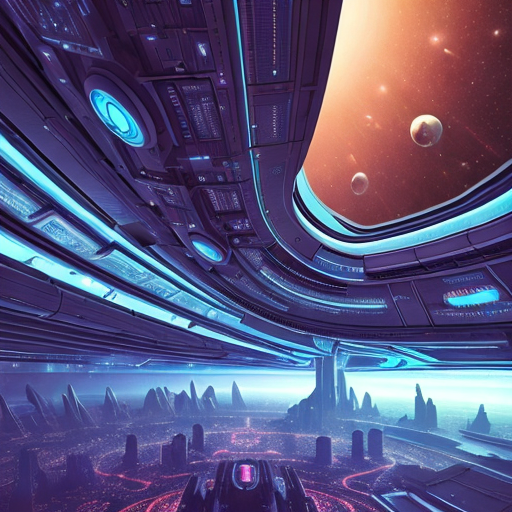

In [2]:
# without using TI
prompt = "a high quality photo of a futuristic city in deep space, midjourney-style"

image = pipe(
    prompt
    , num_inference_steps = 50
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

In [3]:
# load TI
pipe.load_textual_inversion(
    "sd-concepts-library/midjourney-style"
    , token = "midjourney-style"
)

learned_embeds.bin:   0%|          | 0.00/3.82k [00:00<?, ?B/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--sd-concepts-library--midjourney-style. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Asus

  0%|          | 0/50 [00:00<?, ?it/s]

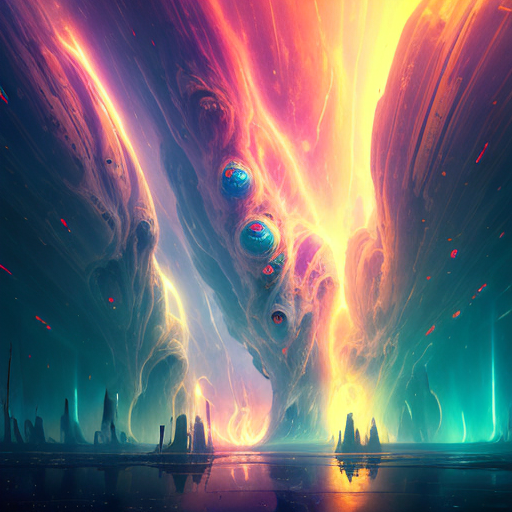

In [4]:
prompt = "a high quality photo of a futuristic city in deep space, midjourney-style"

image = pipe(
    prompt
    , num_inference_steps = 50
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

## Create a Custom Textual Inversin Loader

### Understand the bin Textual Inversion file

In [5]:
# load a bin TI
import torch
loaded_learned_embeds = torch.load("midjourney_style.bin", map_location="cpu")
keys = list(loaded_learned_embeds.keys())
for key in keys:
    print(key,":",loaded_learned_embeds[key])

<midjourney-style> : tensor([-5.9785e-02, -3.8523e-02,  5.1913e-02,  8.0925e-03, -6.2018e-02,
         1.3361e-01,  1.3679e-01,  8.2224e-02, -2.0598e-01,  1.8543e-02,
         1.9180e-01, -1.5537e-01, -1.5216e-01, -1.2607e-01, -1.9420e-01,
         1.0445e-01,  1.6942e-01,  4.2150e-02, -2.7406e-01,  1.8115e-01,
        -1.2176e-01,  1.3681e-01, -5.1796e-02,  7.2207e-02,  1.9783e-01,
        -1.1948e-01,  7.4493e-02, -2.6235e-01,  4.4690e-02,  8.6532e-02,
         8.3066e-02,  1.9744e-02, -3.6112e-02,  8.3247e-02, -5.9376e-02,
         3.2833e-01,  1.4812e-01,  2.4933e-02, -1.2418e-01, -5.4457e-02,
        -1.9538e-01, -1.7045e-01,  1.0564e-01,  7.6027e-02, -1.6175e-01,
         1.6601e-01, -3.1234e-02,  1.2692e-01, -2.5115e-02, -1.7222e-01,
        -1.3137e-01, -1.5938e-01,  7.9629e-02, -1.7216e-01,  5.6154e-03,
        -6.2878e-03,  1.9894e-01, -2.8129e-01,  1.6194e-01,  2.0041e-01,
         1.1676e-01, -1.0086e-01, -4.0901e-02,  7.5425e-02, -5.3958e-03,
        -4.1170e-02,  1.4105e-

In [6]:
# load a pt TI
import torch
loaded_learned_embeds = torch.load("badhandsv5-neg.pt", map_location="cpu")
keys = list(loaded_learned_embeds.keys())
for key in keys:
    print(key,":",loaded_learned_embeds[key])

string_to_token : {'*': 265}
string_to_param : {'*': tensor([[ 0.0399, -0.2473,  0.1252,  ...,  0.0455,  0.0845, -0.1463],
        [-0.1385, -0.0922, -0.0481,  ...,  0.1766, -0.1868,  0.3851]],
       requires_grad=True)}
name : bad-hands-5
step : 1364
sd_checkpoint : 7ab762a7
sd_checkpoint_name : blossom-extract


### Use the custom Textual Inversion 

  0%|          | 0/50 [00:00<?, ?it/s]

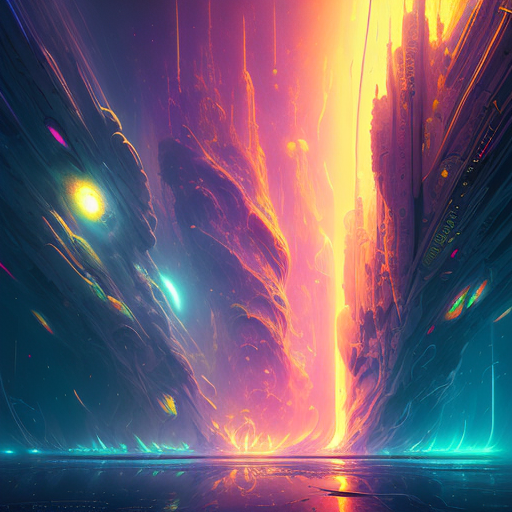

In [7]:
def load_textual_inversion(
    learned_embeds_path
    , token
    , text_encoder
    , tokenizer
    , weight = 0.5
    , device = "cpu"
):
    '''
    Use this function to load textual inversion model in model initilization stage 
    or image generation stage. 
    '''
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location=device)
    if "string_to_token" in loaded_learned_embeds:
        string_to_token = loaded_learned_embeds['string_to_token']
        string_to_param = loaded_learned_embeds['string_to_param']
        
        # separate token and the embeds
        trained_token = list(string_to_token.keys())[0]
        embeds = string_to_param[trained_token]
        embeds = embeds[0] * weight
    elif "emb_params" in loaded_learned_embeds:
        embeds = loaded_learned_embeds["emb_params"][0] * weight
    else:
        keys = list(loaded_learned_embeds.keys())
        embeds =  loaded_learned_embeds[keys[0]] * weight

    # cast to dtype of text_encoder
    dtype = text_encoder.get_input_embeddings().weight.dtype
    embeds.to(dtype)

    # add the token in tokenizer
    token = token if token is not None else trained_token
    num_added_tokens = tokenizer.add_tokens(token)
    if num_added_tokens == 0:
        raise ValueError(
            f"""The tokenizer already contains the token {token}. 
            Please pass a different `token` that is not already in the tokenizer."""
        )
    
    # resize the token embeddings
    text_encoder.resize_token_embeddings(len(tokenizer))
    
    # get the id for the token and assign the embeds
    token_id = tokenizer.convert_tokens_to_ids(token)
    text_encoder.get_input_embeddings().weight.data[token_id] = embeds
    return (tokenizer,text_encoder)

text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer

load_textual_inversion(
    learned_embeds_path = "midjourney_style.bin"
    , token = "colorful-magic-style"
    , text_encoder = text_encoder
    , tokenizer = tokenizer
    , weight = 0.5
    , device = "cuda"
)

prompt = "a high quality photo of a futuristic city in deep space, colorful-magic-style"

image = pipe(
    prompt
    , num_inference_steps = 50
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

## Use Age slider Textual Inversion

In [8]:
textual_inversion_path = "AS-YoungV2-neg.pt"
pipe.load_textual_inversion(textual_inversion_path)

  0%|          | 0/50 [00:00<?, ?it/s]

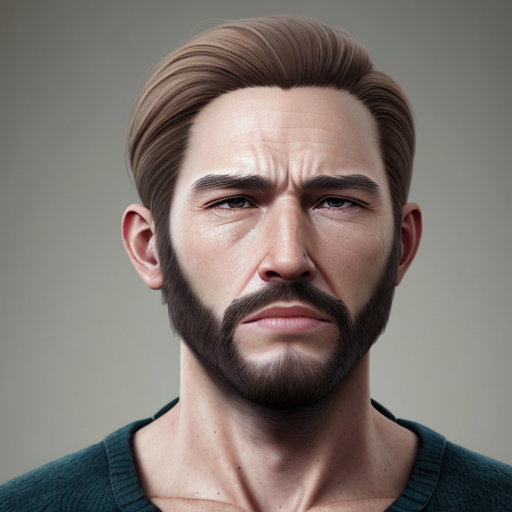

In [9]:
prompt = "a realistic photo of 1man"

image = pipe(
    prompt
    , num_inference_steps = 50
    , generator = torch.Generator("cuda").manual_seed(5)
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

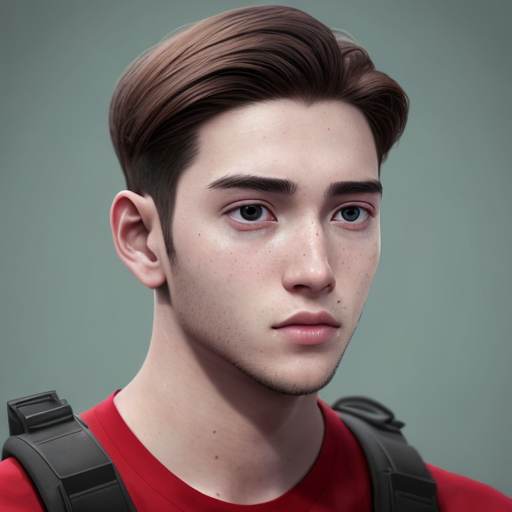

In [10]:
prompt = "AS-YoungestV2,a realistic photo of 1man"
neg_prompt = ""

image = pipe(
    prompt
    , negative_prompt = neg_prompt
    , num_inference_steps = 50
    , generator = torch.Generator("cuda").manual_seed(5)
).images[0]
image